In [1]:
!pip install Mediapipe
!pip install protobuf==3.20.*
!pip install opencv-python


In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings

from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_linnerud
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.multioutput import RegressorChain
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io

warnings.filterwarnings('ignore')

In [3]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [4]:
mylist = [Path(f).stem for f in glob.glob(r"C:\Users\LENOVO\Downloads\ML1-Project\AFLW2000/*.mat")]

In [5]:
file_path = r"C:\Users\LENOVO\Downloads\ML1-Project\AFLW2000"
paths = []
for i in range(len(mylist)):
    mat_path = os.path.join(file_path,mylist[i] + ".mat")
    paths.append(mat_path)

paths


['C:\\Users\\LENOVO\\Downloads\\ML1-Project\\AFLW2000\\image00002.mat',
 'C:\\Users\\LENOVO\\Downloads\\ML1-Project\\AFLW2000\\image00004.mat',
 'C:\\Users\\LENOVO\\Downloads\\ML1-Project\\AFLW2000\\image00006.mat',
 'C:\\Users\\LENOVO\\Downloads\\ML1-Project\\AFLW2000\\image00008.mat',
 'C:\\Users\\LENOVO\\Downloads\\ML1-Project\\AFLW2000\\image00010.mat',
 'C:\\Users\\LENOVO\\Downloads\\ML1-Project\\AFLW2000\\image00013.mat',
 'C:\\Users\\LENOVO\\Downloads\\ML1-Project\\AFLW2000\\image00014.mat',
 'C:\\Users\\LENOVO\\Downloads\\ML1-Project\\AFLW2000\\image00019.mat',
 'C:\\Users\\LENOVO\\Downloads\\ML1-Project\\AFLW2000\\image00020.mat',
 'C:\\Users\\LENOVO\\Downloads\\ML1-Project\\AFLW2000\\image00021.mat',
 'C:\\Users\\LENOVO\\Downloads\\ML1-Project\\AFLW2000\\image00022.mat',
 'C:\\Users\\LENOVO\\Downloads\\ML1-Project\\AFLW2000\\image00023.mat',
 'C:\\Users\\LENOVO\\Downloads\\ML1-Project\\AFLW2000\\image00026.mat',
 'C:\\Users\\LENOVO\\Downloads\\ML1-Project\\AFLW2000\\image0002

In [6]:
def get_ypr_from_mat(mat_path):
    mat = sio.loadmat(mat_path)
    pre_pose_params = mat['Pose_Para'][0]
    pose_params = pre_pose_params[:3]
    return pose_params

ypr_list = []
for index in range(len(paths)):
    ypr_list.append(get_ypr_from_mat(paths[index]))

ypr_df = pd.DataFrame(ypr_list,columns=["yaw","pitch","roll"])
ypr_df['img'] = mylist
ypr_df

,yaw,pitch,roll,img
0,-0.399231,0.018227,0.085676,image00002
1,0.470065,1.189533,0.300959,image00004
2,-0.184650,0.881137,-0.236852,image00006
3,-0.175379,0.299208,-0.373374,image00008
4,-0.882169,1.198004,-1.033374,image00010
...,...,...,...,...
1995,-0.197102,-0.070430,0.105118,image04358
1996,-0.232617,-1.418751,0.175960,image04363
1997,-1.447955,1.431267,-1.509418,image04364
1998,-0.420465,-1.191176,0.451515,image04365


In [7]:
x_relative = []
y_relative = []
img = []
for iter in mylist:
    faceModule = mediapipe.solutions.face_mesh
    # loading image and its correspinding mat file
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image
        image = io.imread(r'C:/Users/LENOVO/Downloads/ML1-Project/AFLW2000/'+iter+'.jpg')
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: 
            for face in results.multi_face_landmarks:
                lst1 = []
                lst2 = []
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    shape = image.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
                    lst1.append(relative_x)
                    lst2.append(relative_y)

                x_relative.append(lst1)
                y_relative.append(lst2)
                img.append(iter)

In [8]:
x_df = pd.DataFrame(x_relative)
y_df = pd.DataFrame(y_relative)
img_df = pd.DataFrame(img , columns=['img'])

In [9]:
concatenated_dfs = pd.concat([x_df, y_df,img_df], axis="columns")

In [10]:
concatenated_dfs

,0,1,2,3,4,5,6,7,8,9,...,459,460,461,462,463,464,465,466,467,img
0,221,221,222,216,222,223,227,163,230,230,...,290,288,294,293,217,221,225,211,206,image00002
1,211,195,208,196,193,195,204,188,205,203,...,275,277,278,279,232,235,237,229,224,image00006
2,226,211,220,200,207,205,204,163,198,194,...,288,284,293,293,225,230,233,205,200,image00008
3,229,221,224,208,218,216,212,158,208,206,...,268,272,273,275,217,220,221,203,201,image00013
4,221,215,219,209,215,215,218,167,218,218,...,264,272,268,271,220,221,222,215,211,image00014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,195,179,195,184,178,181,194,192,195,192,...,269,272,273,274,223,226,229,214,211,image04334
1636,234,251,237,236,253,249,237,143,234,235,...,282,283,288,289,214,218,221,205,198,image04342
1637,231,235,232,224,235,234,231,156,230,231,...,280,284,284,285,224,227,229,221,218,image04344
1638,234,243,235,232,244,242,235,160,233,234,...,283,283,287,288,224,227,230,216,213,image04345


In [11]:
dfff=concatenated_dfs.join(ypr_df.set_index('img'), on='img')

In [12]:
dfff.to_csv("my_data",index=False)

In [13]:
my_data = pd.read_csv(r"C:\Users\LENOVO\Downloads\ML1-Project\my_data")
my_data

,0,1,2,3,4,5,6,7,8,9,...,462.1,463.1,464.1,465.1,466.1,467.1,img,yaw,pitch,roll
0,221,221,222,216,222,223,227,163,230,230,...,293,217,221,225,211,206,image00002,-0.399231,0.018227,0.085676
1,211,195,208,196,193,195,204,188,205,203,...,279,232,235,237,229,224,image00006,-0.184650,0.881137,-0.236852
2,226,211,220,200,207,205,204,163,198,194,...,293,225,230,233,205,200,image00008,-0.175379,0.299208,-0.373374
3,229,221,224,208,218,216,212,158,208,206,...,275,217,220,221,203,201,image00013,-0.026812,0.011965,-0.220662
4,221,215,219,209,215,215,218,167,218,218,...,271,220,221,222,215,211,image00014,0.057119,0.110732,-0.043283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,195,179,195,184,178,181,194,192,195,192,...,274,223,226,229,214,211,image04334,-0.202474,1.198175,-0.352237
1636,234,251,237,236,253,249,237,143,234,235,...,289,214,218,221,205,198,image04342,-0.482186,-0.389773,0.056335
1637,231,235,232,224,235,234,231,156,230,231,...,285,224,227,229,221,218,image04344,-0.173351,-0.060273,0.000774
1638,234,243,235,232,244,242,235,160,233,234,...,288,224,227,230,216,213,image04345,-0.306358,-0.283822,0.038554


In [14]:
x= my_data.drop(['yaw'	,'pitch'	,'roll','img'],axis=1)
y= my_data[['yaw'	,'pitch'	,'roll']]

In [15]:
X_train, X_test, y_train, y_test= train_test_split(x, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor

In [17]:
regr = MultiOutputRegressor(SVR(C=3,epsilon=0.02,tol=0.00001))

pipe = Pipeline([('scaler', StandardScaler()),('pca',PCA(n_components=500)), ('svr', regr)])

In [18]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=500)),
                ('svr',
                 MultiOutputRegressor(estimator=SVR(C=3, epsilon=0.02,
                                                    tol=1e-05)))])

In [19]:
pipe.score(X_test, y_test)

0.8420867183635113

In [20]:
y_perd=pipe.predict(X_test)

In [21]:
print("R2 score: ", r2_score(y_test, y_perd))
print("MSE: ", mean_squared_error(y_test, y_perd))

R2 score:  0.8420867183635113
MSE:  0.01293833658012853


In [22]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(pipe, open(filename, 'wb'))


In [23]:
loaded_model = pickle.load(open(filename, 'rb'))


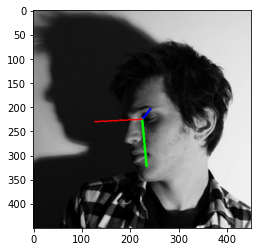

In [24]:
image = io.imread(r'C:/Users/LENOVO/Downloads/ML1-Project/AFLW2000/'+'image00077'+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat(r'C:/Users/LENOVO/Downloads/ML1-Project/AFLW2000/'+'image00077'+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
plt.imshow(draw_axis(image,pitch,yaw,roll))

In [25]:
def get_mesh_data(image,draw_mesh=False):
    faceModule = mediapipe.solutions.face_mesh
    x_relative = []
    y_relative = []
    images_data = []
    mesh_image = image.copy()

    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # collecting image data (x, y of face landmark and pitch, yaw, roll)
        image_data = []
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        if results.multi_face_landmarks != None:
            # looping over the faces in the image
            for face in results.multi_face_landmarks:
                lst1=[]
                lst2=[]
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                    shape = image.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    lst1.append(relative_x)
                    lst2.append(relative_y)
                    if draw_mesh:
                        cv2.circle(mesh_image, (relative_x, relative_y), radius=1, color=(0, 200, 0), thickness=2)
                    
                x_relative.append(lst1)
                y_relative.append(lst2)
     
    df1 = pd.DataFrame(x_relative)
    df2 = pd.DataFrame(y_relative)
    df =  pd.concat([df1,df2],axis="columns")
    cols = []
    cols += [x+str(i+1) for i in range(468) for x in ['X']]
    cols += [x+str(i+1) for i in range(468) for x in ['Y']]
    df.columns = cols
    return df, image, mesh_image

In [26]:
cols = []
cols += [x+str(i+1) for i in range(468) for x in ['X']]
cols += [x+str(i+1) for i in range(468) for x in ['Y']]

cols

['X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'X8',
 'X9',
 'X10',
 'X11',
 'X12',
 'X13',
 'X14',
 'X15',
 'X16',
 'X17',
 'X18',
 'X19',
 'X20',
 'X21',
 'X22',
 'X23',
 'X24',
 'X25',
 'X26',
 'X27',
 'X28',
 'X29',
 'X30',
 'X31',
 'X32',
 'X33',
 'X34',
 'X35',
 'X36',
 'X37',
 'X38',
 'X39',
 'X40',
 'X41',
 'X42',
 'X43',
 'X44',
 'X45',
 'X46',
 'X47',
 'X48',
 'X49',
 'X50',
 'X51',
 'X52',
 'X53',
 'X54',
 'X55',
 'X56',
 'X57',
 'X58',
 'X59',
 'X60',
 'X61',
 'X62',
 'X63',
 'X64',
 'X65',
 'X66',
 'X67',
 'X68',
 'X69',
 'X70',
 'X71',
 'X72',
 'X73',
 'X74',
 'X75',
 'X76',
 'X77',
 'X78',
 'X79',
 'X80',
 'X81',
 'X82',
 'X83',
 'X84',
 'X85',
 'X86',
 'X87',
 'X88',
 'X89',
 'X90',
 'X91',
 'X92',
 'X93',
 'X94',
 'X95',
 'X96',
 'X97',
 'X98',
 'X99',
 'X100',
 'X101',
 'X102',
 'X103',
 'X104',
 'X105',
 'X106',
 'X107',
 'X108',
 'X109',
 'X110',
 'X111',
 'X112',
 'X113',
 'X114',
 'X115',
 'X116',
 'X117',
 'X118',
 'X119',
 'X120',
 'X121',
 'X122',
 'X123',
 

In [27]:
def do_some_magic(frame):
    df_frame, frame,frame_mesh = get_mesh_data(frame, draw_mesh=False)
    if df_frame.size > 0:
        df_frame, image, mesh = get_mesh_data(frame)
        y_pred = pipe.predict(df_frame)[0]
        pitch = y_pred[0]
        yaw = y_pred[1]
        roll = y_pred[2]
        tdx = int(df_frame['X3'].values)
        tdy = int(df_frame['Y3'].values)
        print(y_pred)
        return draw_axis(frame_mesh,pitch,yaw,roll, tdx=tdx, tdy=tdy, size=50)
    else:
        return frame
    


In [29]:
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while True:
    c = cv2.waitKey(1) 
    ret, frame = cap.read()
    
    if frame is not None and ret:
            frame = do_some_magic(frame)
#     try:
        
            
#     except:
#         print('Can\'t detect face')
    
    frame = cv2.resize(frame, None, fx=1, fy=1, interpolation=cv2.INTER_AREA)

    cv2.imshow('Pose Detection Application', frame)
    
    if c == 27:
        break

cap.release()
cv2.destroyAllWindows()

[ 0.03777038  0.12524853 -0.11836282]
[ 0.03770435  0.12518095 -0.11832588]
[ 0.03757707  0.12504915 -0.11825627]
[ 0.03764665  0.1251234  -0.11829514]
[ 0.03780321  0.12527989 -0.11838083]
[ 0.0379611   0.12544089 -0.11846967]
[ 0.03794287  0.12542232 -0.118459  ]
[ 0.03805675  0.12553783 -0.11852264]
[ 0.03877998  0.12626669 -0.11892346]
[ 0.03891356  0.12639736 -0.11899555]
[ 0.03844401  0.12592641 -0.11873607]
[ 0.0384404   0.12592519 -0.11873601]
[ 0.03882381  0.1263074  -0.11894636]
[ 0.03836564  0.12584527 -0.11869278]
[ 0.03817163  0.1256528  -0.11858638]
[ 0.03867915  0.12616234 -0.11886617]
[ 0.03862628  0.12611152 -0.11883842]
[ 0.03909463  0.12658485 -0.11909901]
[ 0.03778523  0.1252597  -0.11837128]
[ 0.03878793  0.12628197 -0.11893071]
[ 0.03815908  0.12564388 -0.11858035]
[ 0.03843065  0.12591965 -0.11873166]
[ 0.03764139  0.12511146 -0.11829139]
[ 0.03912291  0.12660567 -0.11911115]
[ 0.03850447  0.12598526 -0.11876941]
[ 0.03933016  0.12681353 -0.11922592]
[ 0.03787803

[ 0.03791528  0.12540534 -0.11844776]
[ 0.0378146   0.12530316 -0.11839209]
[ 0.03806373  0.12555297 -0.11852939]
[ 0.03788268  0.12537127 -0.1184295 ]
[ 0.03839383  0.12588662 -0.11871422]
[ 0.03774834  0.12523521 -0.11835446]
[ 0.03763892  0.12512301 -0.11829271]
[ 0.03806217  0.12555322 -0.1185294 ]
[ 0.0378032   0.12528898 -0.11838446]
[ 0.03779876  0.12528269 -0.11838145]
[ 0.03758344  0.12506727 -0.11826139]
[ 0.03727242  0.12475379 -0.11808822]
[ 0.03734342  0.12482463 -0.11812787]
[ 0.03744767  0.12493176 -0.1181857 ]
[ 0.03759951  0.12508236 -0.11827068]
[ 0.03757676  0.12506048 -0.11825828]
[ 0.03837891  0.12587778 -0.1187084 ]
[ 0.03696497  0.12443258 -0.11791472]
[ 0.03849472  0.12598937 -0.11877041]
[ 0.03830366  0.12579711 -0.1186634 ]
[ 0.03809503  0.12558327 -0.11854671]
[ 0.03857354  0.1260664  -0.11881235]
[ 0.03821521  0.12570931 -0.11861483]
[ 0.03921072  0.1267074  -0.11916642]
[ 0.03944927  0.12694453 -0.11929744]
[ 0.03902841  0.12652052 -0.11906356]
[ 0.03907511

[ 0.03554346  0.12299685 -0.11709723]
[ 0.03554347  0.12299685 -0.11709724]
[ 0.03554346  0.12299687 -0.11709726]
[ 0.0355435   0.12299688 -0.11709732]
[ 0.03554368  0.12299674 -0.11709768]
[ 0.03556741  0.12301068 -0.11711414]
[ 0.03556741  0.12301068 -0.11711414]
[ 0.03665919  0.1241187  -0.11773728]
[ 0.0544358   0.14098027 -0.12693973]
[ 0.0982069   0.17760467 -0.1462132 ]
[ 0.16256379  0.20634714 -0.15707494]
[ 0.13442003  0.07677878 -0.07085449]
[ 0.04818993 -0.07643975  0.02357434]
[-0.14602219 -0.3858299   0.21139521]
[-0.43916072 -0.77484401  0.44059338]
[-0.67772797 -1.04193318  0.59265154]
[-0.67772797 -1.04193318  0.59265154]
[-0.76688264 -1.11086764  0.62797496]
[-0.77096807 -1.0674662   0.59717229]
[-0.58567373 -0.7696907   0.41617096]
[-0.40305278 -0.49930832  0.25386413]
[-0.25337132 -0.28296064  0.12449931]
[-0.1887186  -0.19093815  0.06961484]
[-0.19571905 -0.20201718  0.07633405]
[-0.19589555 -0.20143731  0.07590516]
[-0.18601248 -0.18841209  0.06824068]
[-0.19269281

[ 0.07238918  0.15742097 -0.13583054]
[ 0.06197796  0.14835489 -0.1309982 ]
[ 0.05084605  0.13799991 -0.12537124]
[ 0.04874358  0.13600798 -0.12428329]
[ 0.04399483  0.13146466 -0.12179402]
[ 0.04374976  0.13122116 -0.12165942]
[ 0.04469172  0.13214355 -0.1221676 ]
[ 0.04285684  0.13034311 -0.12117554]
[ 0.04431569  0.1317668  -0.12195943]
[ 0.04491246  0.13234293 -0.12227582]
[ 0.04419664  0.13165007 -0.12189533]
[ 0.04375791  0.13121096 -0.12165233]
[ 0.04315873  0.13064246 -0.12134098]
[ 0.04347719  0.13095913 -0.12151591]
[ 0.04291813  0.13040627 -0.12121052]
[ 0.04405455  0.13153951 -0.12183743]
[ 0.04367309  0.13118214 -0.12164263]
[ 0.04096401  0.12851831 -0.12017243]
[ 0.04111579  0.12867012 -0.12025657]
[ 0.04347329  0.13103417 -0.12156716]
[ 0.05667705  0.14386431 -0.1286237 ]
[ 0.05713205  0.1442483  -0.12882666]
[ 0.05281518  0.1400733  -0.12653384]
[ 0.04965476  0.13704014 -0.1248713 ]
[ 0.04383025  0.13135322 -0.12173976]
[ 0.04007377  0.1276088  -0.1196674 ]
